In [34]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import s3fs
import tqdm
import subprocess
import shutil, os, glob
import genomeview
import pyBigWig
from plotnine import *
import plotnine

def extract_bw_trace(input_bw, chrom, start, end):
    with pyBigWig.open(input_bw) as bw:
        bw_arr = bw.values(chrom, start, end, numpy=True)
    return bw_arr

def plotdf_bw_series(bw_fn_list, sample_name_list, chrom, start, end):
    results_df = pd.DataFrame()
    for bw_fn,sample_name in zip(bw_fn_list, sample_name_list):
        results_slice = pd.DataFrame({'coverage':extract_bw_trace(bw_fn, chrom, start, end).tolist()})
        results_slice['sample'] = sample_name
        results_slice['pos'] = [x for x in range(start,end)]
        results_df = results_df.append(results_slice)
    return results_df

geneoi_dict = {'g62617.t1':'FBN2',
                'g57506.t1':'BHF',
                'g52047.t1':'RAS10',
                'g50001.t1':'g50001.t1',
                'g71735.t1':'Ahcy',
                'g30477.t1':'VIM',
                'g12356.t1':'FUCA2',
                'g157.t1':'Ahcyl2',
                'g20706.t1':'TKT',
                'g64098.t1':'HrPost-1',
                'g25119.t1':'BAZ2B',
                'g39942.t1':'SMTN',
                'g61047.t1':'g61047.t1',
                'g45293.t1':'SRCAP',
                'g10197.t1':'g10197.t1',
                'g3743.t1':'g3743.t1',
                'g39745.t1':'MASP2',
                'g9431.t1':'Fcn2',
                'g21426.t1':'PARP4',
                'g63396.t1':'Tnn',
                'g32977.t1':'Matn2',
                'g55099.t1':'STT3B',
                'g43887.t1':'LTBP4',
                'g43280.t1':'RASGEF1C',
              }
geneid_list = [x for x,y in geneoi_dict.items()]
genedesc_list = [y for x,y in geneoi_dict.items()]

color_dict = {'Partner 1 soma naive':'#fe0000',
              'Partner 1 test naive':'#feb2b2', 
              'Partner 2 soma naive':'#0000fe', 
              'Partner 2 test naive':'#b2b2fe', 
              'Chimera soma':'#004c00', 
              'Chimera test':'#b2c9b2', 
#               "#D55E00", 
#               "#CC79A7",
             }


In [24]:
crosses_df = (pd.read_csv('s3://darmanis-group/danle/botryllus/botryllus_samples.csv')
              .rename(columns={
                  'Partner 1 soma naaive':'Partner 1 soma naive',
                  'Partner 1 test naïve':'Partner 1 test naive',
                  'Partner 2 soma naaiv':'Partner 2 soma naive',
                  'Partner 2 test naïve':'Partner 2 test naive',
                  'Cimera test':'Chimera test',
                              }
                     )
             )
crosses_df = crosses_df[[x is not np.nan for x in crosses_df['Chimeras set']]] # remove all nan rows
crosses_df['Chimeras set'] = [x.replace(' ', '_') \
                                 .replace('set', 'Set') \
                                 for x in crosses_df['Chimeras set']]
targetfn_df = pd.melt(crosses_df, id_vars=['Chimeras set','Time chimera sampled following fusion'])
targetfn_df['translated_value'] = [ x.replace(' ', '_') \
                                     .replace('  ', '_') \
                                     .replace('.', '_') \
                                     .replace('..', '_') \
                                     .replace('-', '_') \
                                     .replace('--', '_') \
                                     .replace('__', '_') \
                                     .replace('ï','i') if x is not np.nan \
                                   else x \
                                   for x in targetfn_df['value']
                                  ]
# create sample id conversion
value2id_dict = {}
for val_val, key_val in enumerate(targetfn_df['translated_value'].drop_duplicates().dropna()):
    value2id_dict[key_val] = f'sample_{val_val}'
value2id_dict[np.nan] = np.nan
targetfn_df['sample_id'] = [value2id_dict.get(x) for x in targetfn_df['translated_value']]
id2value_dict = {y:x for x,y in value2id_dict.items()} # translate back

# project new sample ids on original experiment matrix
for variable_val in set(targetfn_df['variable']):
    crosses_dict = {}
    targetfn_slice = targetfn_df[targetfn_df['variable']==variable_val]
    targetfn_slice = targetfn_slice[[x is not np.nan for x in targetfn_slice['value']]]
    for row_idx in range(len(targetfn_slice)):
        targetfn_slice_slice = targetfn_slice.iloc[row_idx, :]
        keyval = targetfn_slice_slice['value']
        valval = targetfn_slice_slice['sample_id']
        crosses_dict[keyval] = valval
    crosses_dict[np.nan] = np.nan
    crosses_df[variable_val] = [crosses_dict.get(x) for x in crosses_df[variable_val]]


In [25]:
fs_df = pd.read_csv('/mnt/ibm_lg/daniel_le/data/botryllus/fs.txt', header=None)
fs_df.columns = ['path']
fs_df['fastq'] = [x.endswith('q.gz') for x in fs_df['path']]
fs_df = fs_df[fs_df['fastq'] == True]
fs_df['fn'] = [x.split('/')[-1] for x in fs_df['path']]
fs_df['d1_dir'] = [x.split('/')[-2] for x in fs_df['path']]
fs_df['d1_dir_translated'] = [ x.replace(' ', '_') \
                                 .replace('  ', '_') \
                                 .replace('.', '_') \
                                 .replace('..', '_') \
                                 .replace('-', '_') \
                                 .replace('--', '_') \
                                 .replace('__', '_') \
                               for x in fs_df['d1_dir']
                              ]
fs_df['fn_translated'] = [ x.replace(' ', '_') \
                                 .replace('  ', '_') \
                                 .replace('.', '_') \
                                 .replace('..', '_') \
                                 .replace('-', '_') \
                                 .replace('--', '_') \
                                 .replace('__', '_') \
                               for x in fs_df['fn']
                              ]


In [26]:
match_df = pd.DataFrame()
for target in tqdm.tqdm(targetfn_df['translated_value'].drop_duplicates().dropna()):
    if '944axByd196_6_x_sc109e_92' in target:
        word_len = 30
    else:
        word_len = len(target)
    fs_df_slice = fs_df[[x.startswith(target[:word_len]) or y.startswith(target[:word_len]) \
                         for x,y in zip(fs_df['fn_translated'], fs_df['d1_dir_translated'])]]
    fs_df_slice['target'] = target
    match_df = match_df.append(fs_df_slice)
match_df['sample_id'] = [value2id_dict.get(x) for x in match_df['target']]
match_df = match_df.drop_duplicates()

# metrics
targets = set(targetfn_df['translated_value'].dropna())
print('targets:', len(targets))

hits = set(match_df['target'])
print('hits:', len(hits))

missing = targets-hits
[print(x) for x in missing]


  0%|          | 0/98 [00:00<?, ?it/s]/home/daniel_le/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
100%|██████████| 98/98 [00:00<00:00, 260.91it/s]

targets: 98
hits: 97
3966_944axByd196_6_x_sc109e_92_resorbing_zooid_early_D_chimera_944_side_DCRS


[None]

In [27]:
# check if R1/R2 are properly paired
match_df['fn_translated_prefix'] = [(x
                                     .replace('-R1.','_R2_')
                                     .replace('_R1_','_R2_')
                                    ) for x in match_df['fn_translated']]
match_df_check = pd.DataFrame(match_df
                              .groupby('sample_id')['fn_translated_prefix']
                              .value_counts()
                              .rename('count')).reset_index()
match_df_check[match_df_check['count']!=2]


,sample_id,fn_translated_prefix,count


In [28]:
run_me = False
testing = False

if run_me == True:
    output_dir = '/mnt/ibm_lg/daniel_le/data/botryllus/results/'
    tmp_dir = '/mnt/ibm_lg/daniel_le/data/botryllus/tmp/'
    indexed_fasta = '/mnt/ibm_lg/daniel_le/data/botryllus/genome/botznik-chr.fa'
    star_index = '/mnt/ibm_lg/daniel_le/data/botryllus/genome/star_index'
    n_threads = 16

    # update queue based on completed targets
    queued_targets = list(set(match_df['sample_id']))
    completed_targets = glob.glob(f'{output_dir}*.bw')
    completed_targets = [x.split('/')[-1].split('_Aligned')[0] for x in completed_targets]
    queued_targets = list(set(queued_targets)-set(completed_targets))

    # iterate through queue
#     for sample in tqdm.tqdm(queued_targets):
    if testing == True:
        queued_targets = ['sample_73']
    
    for sample in tqdm.tqdm(queued_targets): # for single testing
        print('starting', sample)
        # prep tmp folder
        if os.path.exists(tmp_dir):
            shutil.rmtree(tmp_dir)
            os.mkdir(tmp_dir)
        else:
            os.mkdir(tmp_dir)
        # prep output foler    
        if os.path.exists(output_dir):
            pass
        else:
            os.mkdir(output_dir)

    #     # set file names
        tmp_R1_fn = f'{tmp_dir}R1.fq.gz'
        tmp_R2_fn = f'{tmp_dir}R2.fq.gz'
        tmp_sam = f'{tmp_dir}{sample}.sam'
        tmp_bam = f'{tmp_dir}{sample}.bam'
        output_sortedbam = f'{output_dir}{sample}.sorted.bam'

        # rclone subprocess call to download files
        match_df_slice = match_df[match_df['sample_id'] == sample]
        input_fastqs = match_df_slice['path'].tolist()
        for input_path in input_fastqs:
            subprocess.call(['rclone',
                             'copy',
                             f'gdrive:Botryllus/{input_path}',
                             tmp_dir,
                            ])

        # extract files in tmp for cat
        R1_inputs = sorted([x for x in glob.glob(f'{tmp_dir}*') if ('-R1.' in x) or ('_R1_' in x)])
        R2_inputs = sorted([x for x in glob.glob(f'{tmp_dir}*') if ('-R2.' in x) or ('_R2_' in x)])
        for inputs,outfn in zip([R1_inputs,R2_inputs], [tmp_R1_fn,tmp_R2_fn]):
            for input_fn in inputs:
                with open(outfn, 'a') as outfile:
                    subprocess.call(['cat', input_fn], stdout=outfile)

#         # run bwa mem
#         with open(tmp_sam, 'w') as outfile:
#             subprocess.call(['bwa',
#                              'mem',
#                              '-t',
#                              str(n_threads),
#                              '-M',
#                              indexed_fasta,
#                              tmp_R1_fn,
#                              tmp_R2_fn,
#                             ], stdout=outfile)

        ### RUN STAR ###
        bam_path = f'{tmp_dir}{sample}_Aligned.sortedByCoord.out.bam'
        subprocess.call(['STAR',
                         '--genomeDir',
                         star_index,
                         '--readFilesCommand',
                         'zcat',
                         '--runThreadN',
                         str(n_threads),
                         '--readFilesIn',
                         tmp_R1_fn,
                         tmp_R2_fn,
                         '--outFileNamePrefix',
                         f'{tmp_dir}{sample}_',
                         '--outSAMtype',
                         'BAM',
                         'SortedByCoordinate',
                         '--outSAMunmapped',
                         'Within',
                         '--outSAMattributes',
                         'Standard',
                         '--twopassMode',
                         'Basic',
                         '--outSAMmapqUnique',
                         '60', # only for GATK, 255 for cufflinks
                         '--outFilterMultimapNmax',
                         '1',
                         '--limitBAMsortRAM',
                         '32000000000'
                        ])

#         # samtools convert sam to bam
#         with open(tmp_bam, 'w') as outfile:
#             subprocess.call(['samtools',
#                              'view',
#                              '-S',
#                              '-b',
#                              tmp_sam,
#                             ], stdout=outfile)

#         # samtools sort bam
#         with open(output_sortedbam, 'w') as outfile:
#             subprocess.call(['samtools',
#                              'sort',
#                              tmp_bam,
#                             ], stdout=outfile)

        # samtools index sorted bam
        bai_path = f'{bam_path}.bai'
        subprocess.call(['samtools',
                         'index',
                         bam_path,
                        ])

        # create bigwig track
        bw_path = f'{bam_path}.bw'
        bin_size = 1
        subprocess.call(['bamCoverage',
                        '-p',
                        str(n_threads),
                        '--normalizeUsing',
                        'CPM',
                        '--ignoreDuplicates',
                        '--binSize',
                        str(bin_size),
                        '-b',
                        bam_path,
                        '-o',
                        bw_path,
                        ])

        # mv files to results folder
        for fn_target in [bam_path, bw_path, bai_path]:
            shutil.move(fn_target, output_dir)

        print('completed')


In [29]:
crosses_df

,Chimeras set,Partner 1 soma naive,Partner 1 test naive,Partner 2 soma naive,Partner 2 test naive,Chimera soma,Chimera test,Time chimera sampled following fusion
0,Control_1_touch-_5139jL11HMBYSc6ab15_vs_944axB...,sample_0,NaN,sample_31,NaN,sample_47,NaN,touching no blood vessel fused
1,Control_1_touch-_5139jL11HMBYSc6ab15_vs_944axB...,sample_1,NaN,sample_32,NaN,sample_48,NaN,touching no blood vessel fused
2,Control_1_touch-_5139jL11HMBYSc6ab15_vs_944axB...,sample_2,NaN,sample_33,NaN,sample_49,NaN,touching no blood vessel fused
3,Control_1_touch-_5139jL11HMBYSc6ab15_vs_944axB...,sample_3,NaN,sample_34,NaN,sample_50,NaN,touching no blood vessel fused
4,Control_1_touch-_5139jL11HMBYSc6ab15_vs_944axB...,sample_4,NaN,sample_35,NaN,sample_51,NaN,touching no blood vessel fused
5,Control_1_touch-_5139jL11HMBYSc6ab15_vs_944axB...,NaN,NaN,sample_36,NaN,sample_52,NaN,touching no blood vessel fused
6,Set_1_chimera-_5139jL11HMBYSc6ab15_vs_944axBYd...,sample_3,NaN,sample_33,NaN,sample_53,sample_87,2 months
7,Set_1_chimera-_5139jL11HMBYSc6ab15_vs_944axBYd...,sample_4,NaN,sample_34,NaN,sample_54,sample_88,2 months
8,Set_2__chimera_944axBYd196.6.4_vs._HM9axBYd196...,sample_5,NaN,sample_37,NaN,sample_55,sample_89,5 months
9,Set_2__chimera_944axBYd196.6.4_vs._HM9axBYd196...,NaN,NaN,sample_38,NaN,sample_56,NaN,5 months


---
Chimeras set: Set_7_chimera_during_resorption_944axByd196.6_x_sc109e.92
Sampling time: 1 month following fusion during resorption
---
Partner 1 soma naive : 3872_Sc109e_endostyle_and_CI_stageA2_kp
Partner 2 soma naive : HISeq_Sample_944axbyd196_12
Chimera soma : 3972_944axByd196_6_x_sc109e_92_primary_bud_early_D_chimera_944_side_DCRS


/home/daniel_le/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


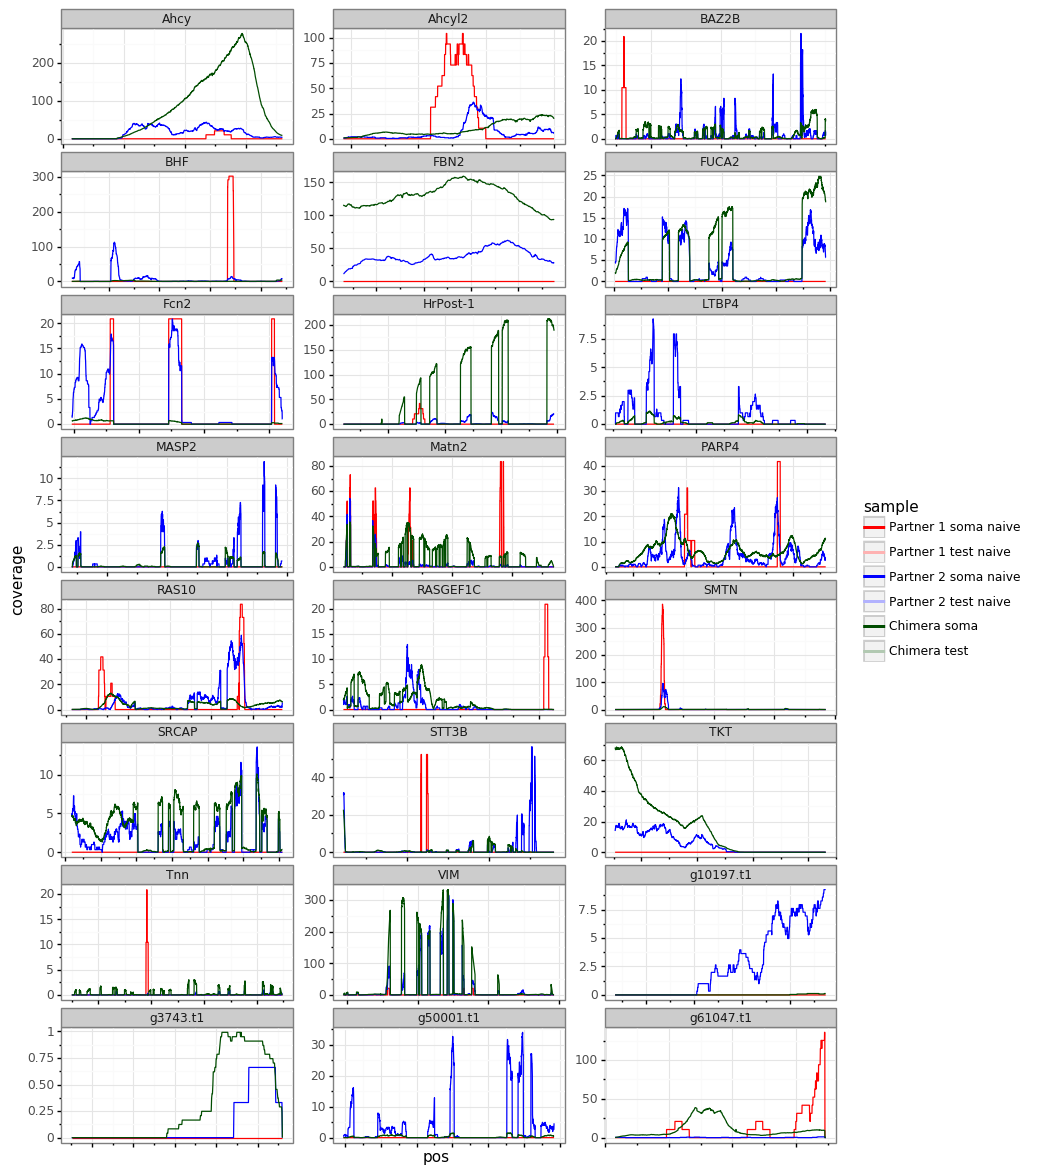

<ggplot: (8756394169849)>


/home/daniel_le/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


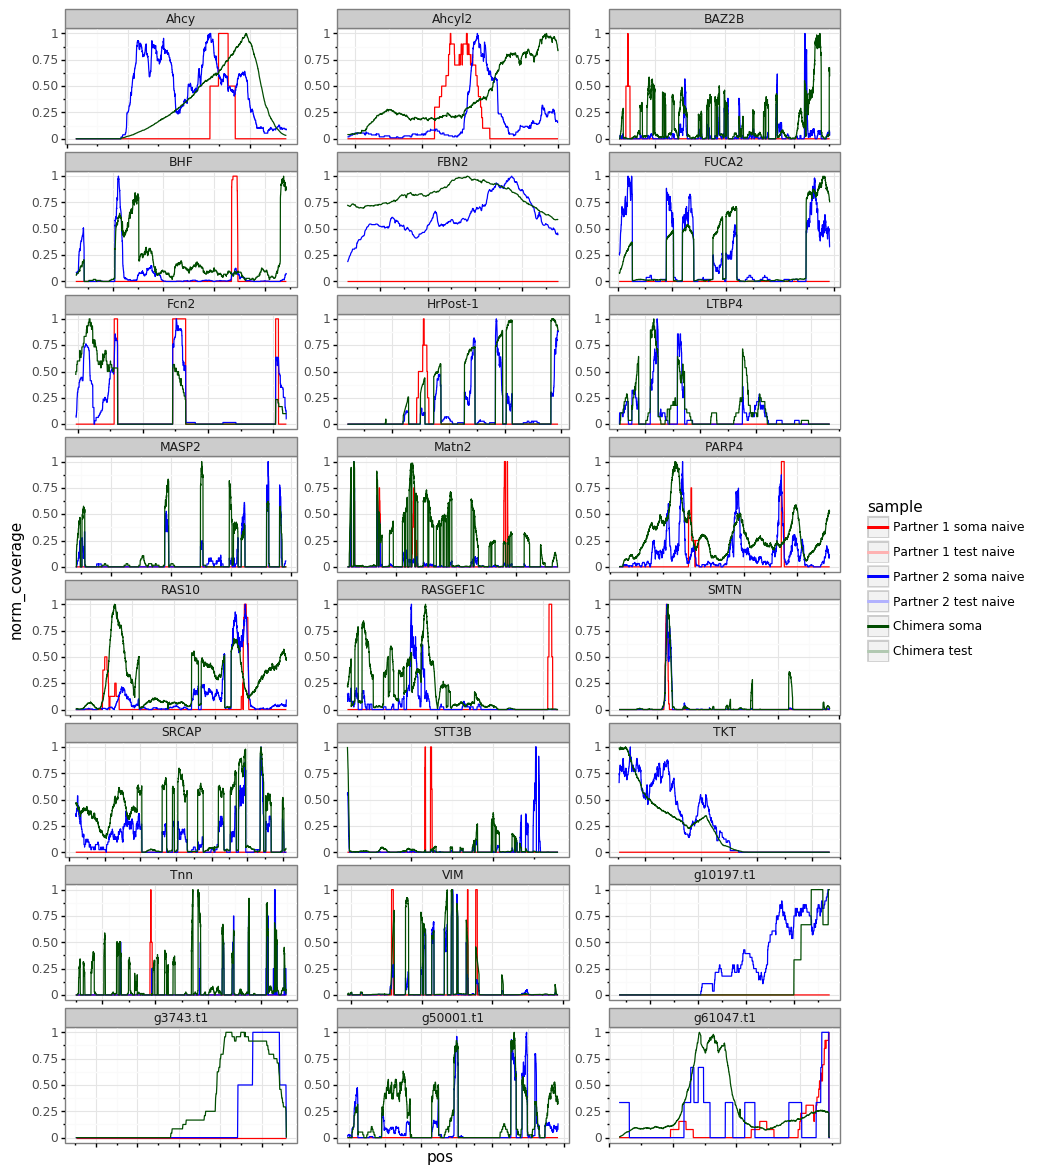

<ggplot: (8756364738457)>


/home/daniel_le/anaconda3/lib/python3.7/site-packages/mizani/bounds.py:352: RuntimeWarning: invalid value encountered in less
  outside = (x < range[0]) | (x > range[1])
/home/daniel_le/anaconda3/lib/python3.7/site-packages/mizani/bounds.py:352: RuntimeWarning: invalid value encountered in greater
  outside = (x < range[0]) | (x > range[1])
/home/daniel_le/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/home/daniel_le/anaconda3/lib/python3.7/site-packages/plotnine/layer.py:452: PlotnineWarning: geom_text : Removed 45 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


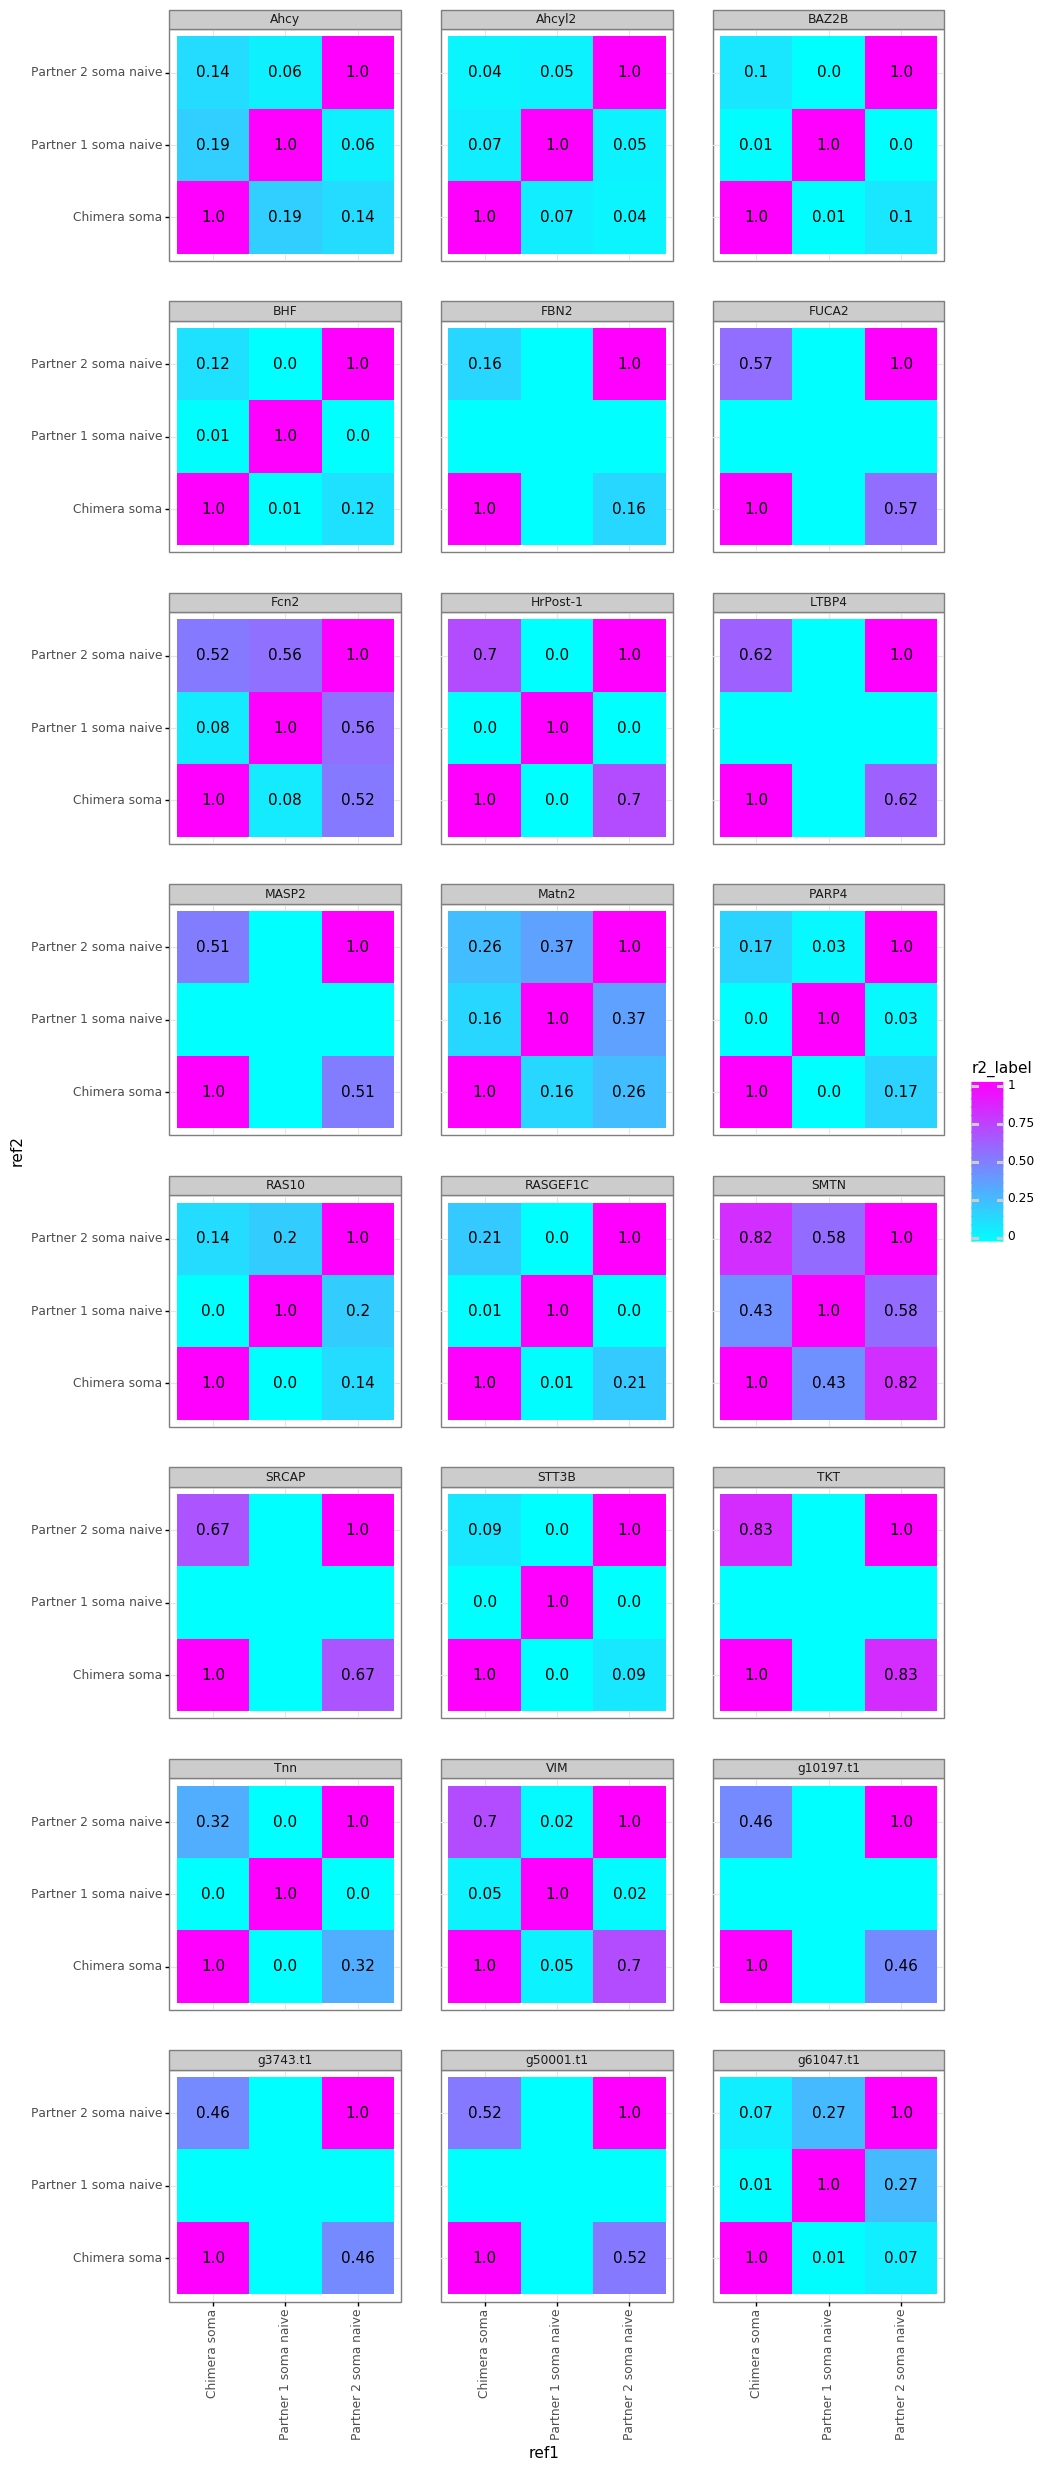

<ggplot: (8756561988953)>


In [42]:
# coverage maps
dump_dir = '/home/daniel_le/data/botryllus/print_outputs/'
multiprint = False
manual_row_idx = 25

if multiprint == True:
    crosses_df.to_csv(f'{dump_dir}sample_sheet.csv')
    idx_bank = crosses_df.index.tolist()
else:
    idx_bank = [manual_row_idx]
    
for row_idx in idx_bank:
    try:
        cross_slice = crosses_df.iloc[row_idx,:].T.tolist()
        cross_slice_dict = crosses_df.iloc[row_idx,:].to_dict()
        chimera_set_val = cross_slice_dict.get('Chimeras set')
        print('---')
        print('Chimeras set:', chimera_set_val)
        print('Sampling time:', cross_slice_dict.get('Time chimera sampled following fusion'))
        print('---')
        cross_slice_dict = {y:x for x,y in cross_slice_dict.items()}
        sample_list = [x.split('_')[-1] for x in cross_slice if str(x).startswith('sample_')]

        fasta_path = '/mnt/ibm_lg/daniel_le/data/botryllus/genome/botznik-chr.fa'
        bin_size = 1

        # plot set
        full_bw_dir = '/mnt/ibm_lg/daniel_le/data/botryllus/results/STAR/'
        bw_fn_list = [f'{full_bw_dir}sample_{sample_index}_Aligned.sortedByCoord.out.bam.bw' for sample_index in sample_list]
        sample_name_list = [cross_slice_dict.get(f'sample_{sample_index}') for sample_index in sample_list]
        for sample_index in sample_list:
            print(cross_slice_dict.get(f'sample_{sample_index}'), 
                  ':',
                  id2value_dict.get(f'sample_{sample_index}')
                 )

        # ingest gene positions in bed file
        genebed_path = '/mnt/ibm_lg/daniel_le/data/botryllus/genome/botznik-chr-all.bed'
        bed_df = pd.read_csv(genebed_path, sep = '\t', header = None)
        bed_df.columns = ['chrom','start','end','name','ph1','ph2','ph3','ph4','ph5','ph6','ph7','ph8']

        # process all genes of interest and append desc.
        master_plotdf = pd.DataFrame()
        for gene_id in geneid_list: 
            chrom = bed_df.query(f'name == "{gene_id}"').chrom.tolist()[0]
            start = bed_df.query(f'name == "{gene_id}"').start.tolist()[0]
            end =   bed_df.query(f'name == "{gene_id}"').end.tolist()[0]

            plotdf = plotdf_bw_series(bw_fn_list, sample_name_list, chrom, start, end)
            plotdf['gene_id'] = gene_id
            plotdf['gene_desc'] = geneoi_dict.get(gene_id)
            plotdf = plotdf.rename(columns={'coverage':'value'})
            plotdf['variable'] = 'coverage'    

            plotdf_norm = (pd.DataFrame(plotdf.groupby(['variable','gene_id','gene_desc','sample','pos'])['value'].sum()/ \
                                       plotdf.groupby(['variable','gene_id','gene_desc','sample'])['value'].max()
                                         )
                            .replace(np.nan, 0)
                            .reset_index()
                          )
            plotdf_norm['variable'] = 'norm_coverage'
            plotdf = plotdf.append(plotdf_norm)
            master_plotdf = master_plotdf.append(plotdf)

        for grid_val in ['coverage', 'norm_coverage']:
            plotdf_filter = master_plotdf.query(f'variable == "{grid_val}"')
            plotdf_filter['sample'] = (plotdf_filter['sample']
                            .astype(str)
                            .astype(CategoricalDtype([x for x in color_dict.keys()], ordered=True))
                           )
            plotnine.options.figure_size = (10,10)
            plot = (ggplot(plotdf_filter)
                    + theme_bw()
                    + theme(aspect_ratio = 1/2,
                            axis_text_x = element_blank(),
                            panel_spacing_x = 0.4,
                           )
                    + geom_line(aes('pos','value',color='sample',group='sample'))
                    + facet_wrap('~gene_desc', scales='free', ncol=3)
                    + labs(y=grid_val, x = 'pos')
                    + scale_color_manual(values=color_dict)
                   )
            if multiprint == False:
                print(plot)
            else:
                sv_fn = f'{dump_dir}{chimera_set_val}_{row_idx}_{grid_val}_linePlot.png'
                ggsave(plot=plot, filename=sv_fn)

        # plot corr matrix
        ref_df = master_plotdf[master_plotdf['variable']=='coverage']
        master_corr = pd.DataFrame()
        for gene_desc_val in set(ref_df.gene_desc):
            ref_slice = (ref_df
                         .query(f'gene_desc == "{gene_desc_val}"')
                          .loc[:,['pos','sample','value']]
                          .pivot(index='pos', columns='sample', values='value')
                         .corr()
                         )
            ref_slice_cols = ref_slice.columns.tolist()
            ref_slice_melt = (pd.melt((ref_slice
                                      .reset_index()
                                      .rename(columns = {'sample':'ref1'})
                                     ), id_vars= ['ref1'])
                              .rename(columns={'sample':'ref2',
                                               'value':'r'
                                              })
                             )
            ref_slice_melt['r2'] =  ref_slice_melt['r'] ** 2
            ref_slice_melt['r2_label'] = ref_slice_melt['r2'].round(2)
            ref_slice_melt['gene_desc'] = gene_desc_val
            master_corr = master_corr.append(ref_slice_melt)

        plot = (ggplot(master_corr)
                + theme_bw()
                + theme(aspect_ratio = 1,
                        axis_text_x = element_text(angle=90),
                        panel_spacing = 0.4,
                       )
                + geom_tile(aes('ref1','ref2',fill='r2_label'))
                + geom_text(aes('ref1','ref2',label='r2_label'))
                + facet_wrap('~gene_desc', ncol=3)
                + scale_fill_cmap('cool')
               )
        if multiprint == False:
            print(plot)
        else:
            sv_fn = f'{dump_dir}{chimera_set_val}_{row_idx}_corrMatrix.png'
            ggsave(plot=plot, filename=sv_fn)
    except Exception as e:
        print (e)
        pass
    

In [40]:
# order sample sets by low variance explained relative to Chimera groups

fasta_path = '/mnt/ibm_lg/daniel_le/data/botryllus/genome/botznik-chr.fa'
genebed_path = '/mnt/ibm_lg/daniel_le/data/botryllus/genome/botznik-chr-all.bed'

# select geneoi
sample_set_priority = pd.DataFrame()
for gene_id in tqdm.tqdm(geneoi_dict.keys()):
    for row_idx in range(len(crosses_df)):
        try:
            cross_slice = crosses_df.iloc[row_idx,:].T.tolist()
            cross_slice_dict = crosses_df.iloc[row_idx,:].to_dict()
            sample_set = cross_slice_dict.get('Chimeras set')
            sampling_time = cross_slice_dict.get('Time chimera sampled following fusion')
            cross_slice_dict = {y:x for x,y in cross_slice_dict.items()}
            sample_list = [x.split('_')[-1] for x in cross_slice if str(x).startswith('sample_')]

            bin_size = 1

            # plot set
            full_bw_dir = '/mnt/ibm_lg/daniel_le/data/botryllus/results/STAR/'
            bw_fn_list = [f'{full_bw_dir}sample_{sample_index}_Aligned.sortedByCoord.out.bam.bw' for sample_index in sample_list]
            sample_name_list = [cross_slice_dict.get(f'sample_{sample_index}') for sample_index in sample_list]

            # ingest gene positions in bed file
            bed_df = pd.read_csv(genebed_path, sep = '\t', header = None)
            bed_df.columns = ['chrom','start','end','name','ph1','ph2','ph3','ph4','ph5','ph6','ph7','ph8']

            # process all genes of interest and append desc.
            master_plotdf = pd.DataFrame()
            chrom = bed_df.query(f'name == "{gene_id}"').chrom.tolist()[0]
            start = bed_df.query(f'name == "{gene_id}"').start.tolist()[0]
            end =   bed_df.query(f'name == "{gene_id}"').end.tolist()[0]

            plotdf = plotdf_bw_series(bw_fn_list, sample_name_list, chrom, start, end)
            plotdf['gene_id'] = gene_id
            plotdf['gene_desc'] = geneoi_dict.get(gene_id)
            plotdf = plotdf.rename(columns={'coverage':'value'})
            plotdf['variable'] = 'coverage'    

            plotdf_norm = (pd.DataFrame(plotdf.groupby(['variable','gene_id','gene_desc','sample','pos'])['value'].sum()/ \
                                       plotdf.groupby(['variable','gene_id','gene_desc','sample'])['value'].max()
                                         )
                            .replace(np.nan, 0)
                            .reset_index()
                          )
            plotdf_norm['variable'] = 'norm_coverage'
            plotdf = plotdf.append(plotdf_norm)
            master_plotdf = master_plotdf.append(plotdf)

            # plot corr matrix
            ref_df = master_plotdf[master_plotdf['variable']=='coverage']
            master_corr = pd.DataFrame()
            gene_desc_val = ref_df.gene_desc.tolist()[0]
            ref_slice = (ref_df
                         .query(f'gene_desc == "{gene_desc_val}"')
                          .loc[:,['pos','sample','value']]
                          .pivot(index='pos', columns='sample', values='value')
                         .corr()
                         )
            ref_slice_cols = ref_slice.columns.tolist()
            ref_slice_melt = (pd.melt((ref_slice
                                      .reset_index()
                                      .rename(columns = {'sample':'ref1'})
                                     ), id_vars= ['ref1'])
                              .rename(columns={'sample':'ref2',
                                               'value':'r'
                                              })
                             )
            ref_slice_melt['r2'] =  ref_slice_melt['r'] ** 2
            ref_slice_melt['r2_label'] = ref_slice_melt['r2'].round(2)
            ref_slice_melt['gene_desc'] = gene_desc_val
            master_corr = master_corr.append(ref_slice_melt)
            master_corr = master_corr[[not x.startswith('Chimera') and y.startswith('Chimera') \
                         for x,y in zip(master_corr['ref1'], master_corr['ref2'])]]
            master_corr = (master_corr
                           .loc[:,['gene_desc','r2']]
                           .groupby(['gene_desc'])
                           .mean()
                           .rename(columns = {'r2':'mean_r2'})
                           .reset_index()
                          )
            master_corr['sample_set'] = ''.join(sample_set.split('_')[:2])
            master_corr['sampling_time'] = sampling_time
            master_corr['row_idx'] = row_idx
            sample_set_priority = sample_set_priority.append(master_corr)

        except:
            print('Failed to process:', sample_set)


  0%|          | 0/24 [00:00<?, ?it/s]

Failed to process: Set_7_chimera_during_resorption_944axByd196.6_x_sc109e.92


  4%|▍         | 1/24 [00:11<04:13, 11.02s/it]

Failed to process: Set_7_chimera_during_resorption_944axByd196.6_x_sc109e.92


  8%|▊         | 2/24 [00:18<03:39,  9.97s/it]

Failed to process: Set_7_chimera_during_resorption_944axByd196.6_x_sc109e.92


 12%|█▎        | 3/24 [00:26<03:14,  9.27s/it]

Failed to process: Set_7_chimera_during_resorption_944axByd196.6_x_sc109e.92


 17%|█▋        | 4/24 [00:33<02:53,  8.66s/it]

Failed to process: Set_7_chimera_during_resorption_944axByd196.6_x_sc109e.92


 21%|██        | 5/24 [00:39<02:30,  7.94s/it]

Failed to process: Set_7_chimera_during_resorption_944axByd196.6_x_sc109e.92


 25%|██▌       | 6/24 [00:50<02:39,  8.87s/it]

Failed to process: Set_7_chimera_during_resorption_944axByd196.6_x_sc109e.92


 29%|██▉       | 7/24 [00:58<02:25,  8.55s/it]

Failed to process: Set_7_chimera_during_resorption_944axByd196.6_x_sc109e.92


 33%|███▎      | 8/24 [01:05<02:11,  8.20s/it]

Failed to process: Set_7_chimera_during_resorption_944axByd196.6_x_sc109e.92


 38%|███▊      | 9/24 [01:12<01:55,  7.67s/it]

Failed to process: Set_7_chimera_during_resorption_944axByd196.6_x_sc109e.92


 42%|████▏     | 10/24 [01:18<01:41,  7.28s/it]

Failed to process: Set_7_chimera_during_resorption_944axByd196.6_x_sc109e.92


 46%|████▌     | 11/24 [01:28<01:46,  8.18s/it]

Failed to process: Set_7_chimera_during_resorption_944axByd196.6_x_sc109e.92


 50%|█████     | 12/24 [01:37<01:40,  8.35s/it]

Failed to process: Set_7_chimera_during_resorption_944axByd196.6_x_sc109e.92


 54%|█████▍    | 13/24 [01:43<01:22,  7.52s/it]

Failed to process: Set_7_chimera_during_resorption_944axByd196.6_x_sc109e.92


 58%|█████▊    | 14/24 [01:50<01:13,  7.40s/it]

Failed to process: Set_7_chimera_during_resorption_944axByd196.6_x_sc109e.92


 62%|██████▎   | 15/24 [01:56<01:01,  6.85s/it]

Failed to process: Set_7_chimera_during_resorption_944axByd196.6_x_sc109e.92


 67%|██████▋   | 16/24 [02:01<00:50,  6.31s/it]

Failed to process: Set_7_chimera_during_resorption_944axByd196.6_x_sc109e.92


 71%|███████   | 17/24 [02:09<00:48,  6.86s/it]

Failed to process: Set_7_chimera_during_resorption_944axByd196.6_x_sc109e.92


 75%|███████▌  | 18/24 [02:14<00:38,  6.43s/it]

Failed to process: Set_7_chimera_during_resorption_944axByd196.6_x_sc109e.92


 79%|███████▉  | 19/24 [02:22<00:34,  6.82s/it]

Failed to process: Set_7_chimera_during_resorption_944axByd196.6_x_sc109e.92


 83%|████████▎ | 20/24 [02:34<00:33,  8.40s/it]

Failed to process: Set_7_chimera_during_resorption_944axByd196.6_x_sc109e.92


 88%|████████▊ | 21/24 [02:44<00:26,  8.88s/it]

Failed to process: Set_7_chimera_during_resorption_944axByd196.6_x_sc109e.92


 92%|█████████▏| 22/24 [02:53<00:18,  9.08s/it]

Failed to process: Set_7_chimera_during_resorption_944axByd196.6_x_sc109e.92


 96%|█████████▌| 23/24 [03:01<00:08,  8.54s/it]

Failed to process: Set_7_chimera_during_resorption_944axByd196.6_x_sc109e.92


100%|██████████| 24/24 [03:09<00:00,  7.88s/it]


/home/daniel_le/anaconda3/lib/python3.7/site-packages/plotnine/layer.py:360: PlotnineWarning: stat_boxplot : Removed 104 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
/home/daniel_le/anaconda3/lib/python3.7/site-packages/plotnine/stats/stat.py:311: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)


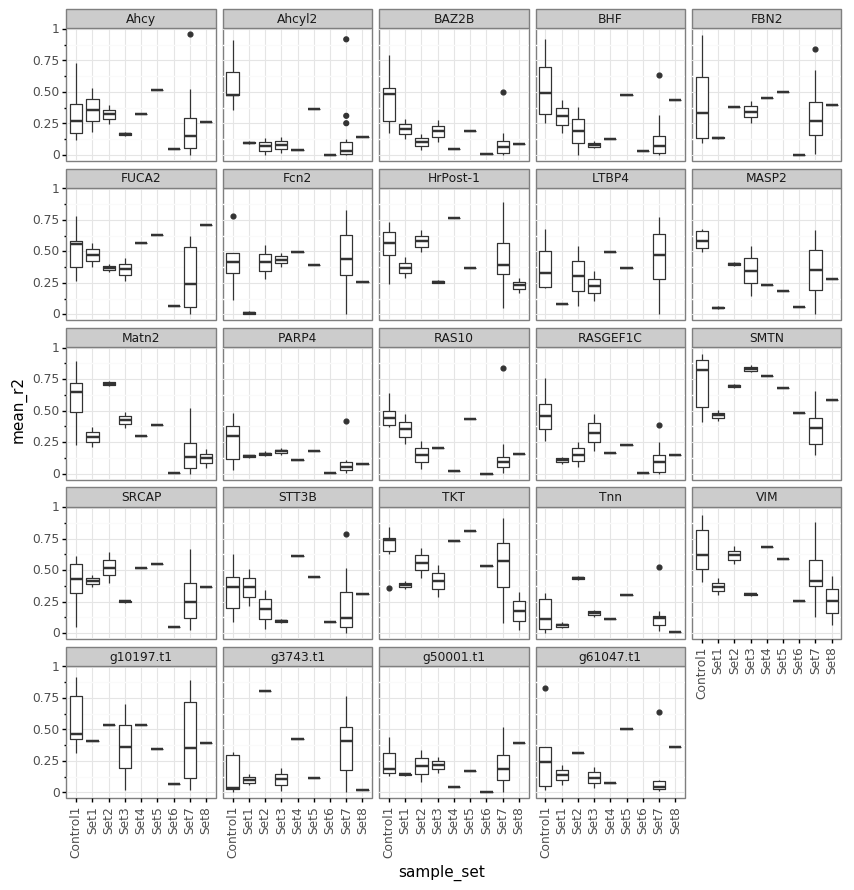

<ggplot: (8756365085365)>

In [41]:
plot = (ggplot(sample_set_priority)
        + theme_bw()
        + theme(axis_text_x = element_text(angle = 90))
        + geom_boxplot(aes('sample_set','mean_r2'))
        + facet_wrap('~gene_desc')
       )
plot